# BART Arabic From Scratch

Implement the [BART: Denoising Sequence-to-Sequence Pre-training](https://arxiv.org/abs/1910.13461) paper from scratch using PyTorch for an abstractive summarization task in Arabic.

## Install & Import Dependencies
Dependency version details are listed in the `requirements.txt` file.

In [ ]:
!pip install -r requirements.txt

In [ ]:
import os
import json
import math
import time
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn, Tensor
from torch.optim import Adam
from torch.utils.data import DataLoader
from torch.nn.utils import clip_grad_norm_
from torch.cuda.amp import GradScaler, autocast
from datasets import Dataset
from tokenizers import ByteLevelBPETokenizer, Tokenizer
from tokenizers.processors import TemplateProcessing

## Download & Load the Datasets
The dataset used is the [XL-Sum(Arabic Subset)](https://github.com/csebuetnlp/xl-sum?tab=readme-ov-file#:~:text=Arabic,Download) dataset. I chose this dataset because it's well-suited for our task. Additionally, it's written in pure Arabic, which makes it the best choice. The original source: [BBC Arabic](https://www.bbc.com/arabic).


In [ ]:
!gdown "https://docs.google.com/uc?export=download&id=1lot6kJ6TPCHuBI6Ky_RQPdYpWaQCk-jl"
!mkdir -p data
!tar -xvjf arabic_XLSum_v2.0.tar.bz2 -C data/
!ls data/

Downloading...
From (original): https://docs.google.com/uc?export=download&id=1lot6kJ6TPCHuBI6Ky_RQPdYpWaQCk-jl
From (redirected): https://docs.google.com/uc?export=download&id=1lot6kJ6TPCHuBI6Ky_RQPdYpWaQCk-jl&confirm=t&uuid=881a1b05-ccb8-43b9-9a16-0da145ee300d
To: /teamspace/studios/this_studio/arabic_XLSum_v2.0.tar.bz2
100%|██████████████████████████████████████| 44.9M/44.9M [00:02<00:00, 20.4MB/s]
./
./arabic_test.jsonl
./arabic_val.jsonl
./arabic_train.jsonl
arabic_test.jsonl  arabic_train.jsonl  arabic_val.jsonl


In [ ]:
data = "data/"

train_file = os.path.join(data, "arabic_train.jsonl")
validation_file = os.path.join(data, "arabic_val.jsonl")
test_file = os.path.join(data, "arabic_test.jsonl")

train_set = pd.read_json(train_file, lines=True)
validation_set = pd.read_json(validation_file, lines=True)
test_set = pd.read_json(test_file, lines=True)

## Exploratory Data Analysis (EDA)

Analyze the data characteristics and features.

In [ ]:
train_set.shape, validation_set.shape, test_set.shape

((37519, 5), (4689, 5), (4689, 5))

In [ ]:
train_set.head()

,id,url,title,summary,text
0,140323_russian_troops_crimea_naval_base,https://www.bbc.com/arabic/worldnews/2014/03/1...,القوات الأوكرانية تبدأ الانسحاب من القرم,بدأت القوات الأوكرانية الانسحاب من شبه جزيرة ا...,وكان الرئيس الأوكراني المؤقت، الكسندر تورتشينو...
1,130528_egypt_nile_dam,https://www.bbc.com/arabic/middleeast/2013/05/...,هل يفرض سد النهضة الإثيوبي واقعا جديدا على مصر؟,"""هل سيتم تغيير العبارة الشهيرة للمؤرخ اليوناني...",بحلول عام 2050 ستحتاج مصر إلى 21 مليار متر مكع...
2,world-47242349,https://www.bbc.com/arabic/world-47242349,تعرف على منطقة كشمير التي تسببت بحربين بين اله...,قالت الشرطة في القطاع الهندي من إقليم كشمير إن...,وذكرت وكالة الأنباء المحلية (جي.إن.إس) أن جماع...
3,vert-cul-55078328,https://www.bbc.com/arabic/vert-cul-55078328,ماذا تعرف عن العالم الخفي للمعابد اليابانية ال...,في عام 816، تجول راهب يدعى كوكاي، في المنحدرات...,ووقع اختياره على واد عمقه 800 متر محاط بثماني ...
4,141023_yemen_hodeida,https://www.bbc.com/arabic/middleeast/2014/10/...,"اشتباك بين الحوثيين و""الحراك التهامي"" في الحدي...","أكد مصدر في ""الحراك التهامي"" لأبناء محافظة الح...",مسلح حوثي في إب وقال المصدر إن المسلحين الحوثي...


In [ ]:
validation_set.head()

,id,url,title,summary,text
0,140921_yemen_pm_resign,https://www.bbc.com/arabic/middleeast/2014/09/...,اتفاق لتشكيل حكومة جديدة بين الحوثيين وعدة احز...,وقع الحوثيون اتفاقا مع عدد من الاحزاب اليمنية ...,انضم بعض عناصر القوات المسلحة الى الحوثيين في ...
1,inthepress-56197077,https://www.bbc.com/arabic/inthepress-56197077,مظاهرات تونس: إلى أي مدى سيصل الصراع بين أطراف...,ناقش معلقون في صحف عربية تطور الأزمة السياسية ...,الرئيس التونسي قيس سعيد ورئيس الحكومة هشام الم...
2,151114_gatwick_airport_frenchman_charged,https://www.bbc.com/arabic/worldnews/2015/11/1...,اتهام رجل بحيازة أسلحة بعد إعلان حالة تأهب في ...,اتهمت الشرطة البريطانية رسميا رجلا فرنسيا بحيا...,المسافرون انتظروا ست ساعات على أرض مطار غاتويك...
3,media-48880286,https://www.bbc.com/arabic/media-48880286,عالم سري للسوريّات على فيسبوك محظور على الرجال...,تطلب شابة على إحدى صفحات فيسبوك المغلقة نصيحة ...,وانهالت تعليقات النساء على هذه المداخلة بين مؤ...
4,130311_us_nkorea,https://www.bbc.com/arabic/middleeast/2013/03/...,الولايات المتحدة توسع العقوبات ضد كوريا الشمالية,فرضت الولايات المتحدة عقوبات على بنك العملة ال...,قطعت كوريا الشمالية الخط الهاتفي الساخن بين ال...


In [ ]:
test_set.head()

,id,url,title,summary,text
0,130806_nidhal_hassan_trial,https://www.bbc.com/arabic/worldnews/2013/08/1...,نضال حسن يمثل أمام محكمة عسكرية أمريكية,تنظر محكمة عسكرية أمريكية في وقت لاحق من اليوم...,نضال حسن واعترف نضال حسن، الذي يدافع عن نفسه، ...
1,160129_germany_asylum_seekers,https://www.bbc.com/arabic/worldnews/2016/01/1...,ألمانيا تسعى للحد من الهجرة بإعلان الجزائر وتو...,كشفت ألمانيا النقاب عن خطط لإضافة الجزائر والم...,ألمانيا تواجه مصاعب في التعامل مع الأعداد المت...
2,130729_syria_homs_area_retaken,https://www.bbc.com/arabic/middleeast/2013/07/...,الخالدية : التليفزيون السوري يعلن استعادة الجي...,قال التليفزيون السوري إن قوات الحكومة استعادت ...,"وأكدت وسائل الإعلام السورية أن الجيش ""استعاد ا..."
3,140517_arsenal_fa_cup_winners,https://www.bbc.com/arabic/sports/2014/05/1405...,الارسنال يتوج بلقب كأس انكلترا,توج فريق الارسنال ببطولة كأس انجلترا لكرة القد...,وفاجأ هال سيتي الحضور بمباغتة الارسنال بهدفين ...
4,140722_iraq_minorities,https://www.bbc.com/arabic/middleeast/2014/07/...,العراق: الأقليات في سهل نينوى,يوضع الصراع في العراق غالبا في إطار صراع بين ا...,معبد يزيدي في سهول محافظة نينوى يعيش المسيحيون...


### Visualize sequence length distribution to decide the maximum length for source and target sequences

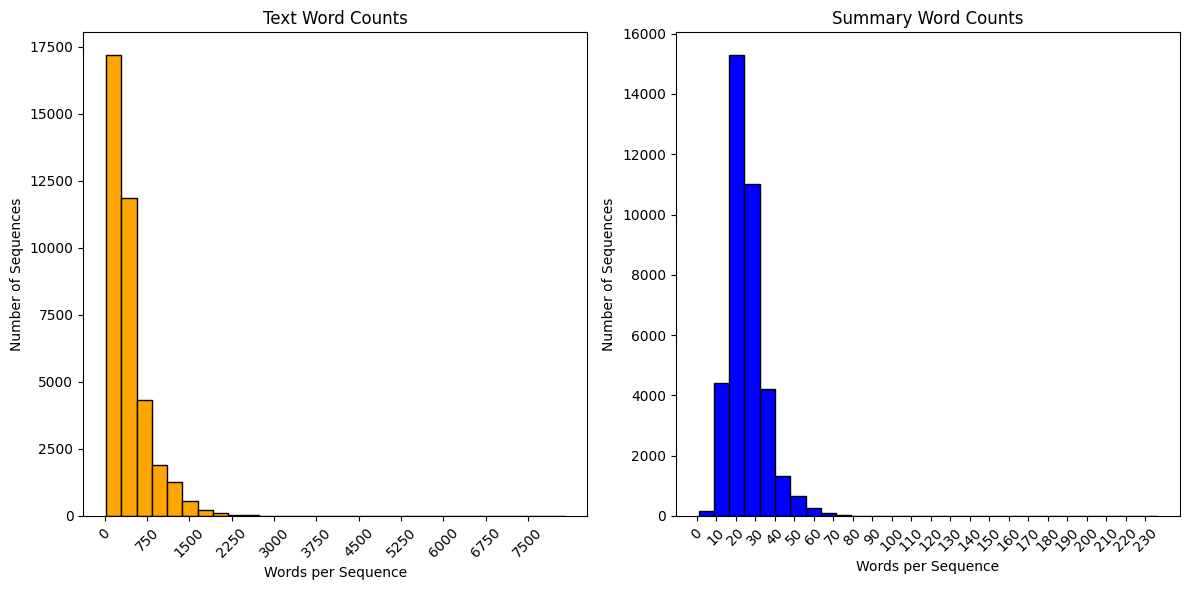

In [ ]:
train_set["text_length"] = train_set["text"].apply(lambda x: len(x.split()))
train_set["summary_length"] = train_set["summary"].apply(lambda x: len(x.split()))

text_length_min, text_length_max = train_set["text_length"].min(), train_set["text_length"].max()
summary_length_min, summary_length_max = train_set["summary_length"].min(), train_set["summary_length"].max()

text_ticks = range(0, text_length_max + 1, 750)
summary_ticks = range(0, summary_length_max + 1, 10)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(train_set["text_length"], bins=30, color="orange", edgecolor="black", range=(text_length_min, text_length_max))
plt.title("Text Word Counts")
plt.xlabel("Words per Sequence")
plt.ylabel("Number of Sequences")
plt.xticks(ticks=text_ticks, rotation=45)

plt.subplot(1, 2, 2)
plt.hist(train_set["summary_length"], bins=30, color="blue", edgecolor="black", range=(summary_length_min, summary_length_max))
plt.title("Summary Word Counts")
plt.xlabel("Words per Sequence")
plt.ylabel("Number of Sequences")
plt.xticks(ticks=summary_ticks, rotation=45)

plt.tight_layout()
plt.show()

## Clean the Datasets
Remove unnecessary features and clean the datasets of duplicates and non-representative samples.

In [ ]:
columns = ["id", "url", "title"]

train_set.drop(columns=columns, inplace=True)
validation_set.drop(columns=columns, inplace=True)
test_set.drop(columns=columns, inplace=True)

train_set.shape, validation_set.shape, test_set.shape

((37519, 4), (4689, 2), (4689, 2))

In [ ]:
train_set.drop_duplicates(subset=["text"], inplace=True)
validation_set.drop_duplicates(subset=["text"], inplace=True)
test_set.drop_duplicates(subset=["text"], inplace=True)

train_set.shape, validation_set.shape, test_set.shape

((37425, 4), (4689, 2), (4689, 2))

In [ ]:
train_set.head()

,summary,text,text_length,summary_length
0,بدأت القوات الأوكرانية الانسحاب من شبه جزيرة ا...,وكان الرئيس الأوكراني المؤقت، الكسندر تورتشينو...,525,8
1,"""هل سيتم تغيير العبارة الشهيرة للمؤرخ اليوناني...",بحلول عام 2050 ستحتاج مصر إلى 21 مليار متر مكع...,462,40
2,قالت الشرطة في القطاع الهندي من إقليم كشمير إن...,وذكرت وكالة الأنباء المحلية (جي.إن.إس) أن جماع...,106,32
3,في عام 816، تجول راهب يدعى كوكاي، في المنحدرات...,ووقع اختياره على واد عمقه 800 متر محاط بثماني ...,1343,32
4,"أكد مصدر في ""الحراك التهامي"" لأبناء محافظة الح...",مسلح حوثي في إب وقال المصدر إن المسلحين الحوثي...,185,55


In [ ]:
train_set.tail()

,summary,text,text_length,summary_length
37514,*هذا الفيديو بدون تعليق*,يثور بركان بولسكي تولباشيك شرقي روسيا منذ نوفم...,47,4
37515,بي بي سي ترند تقرير مي نعمان,بينما احتدمت أزمة احتجاز الرهائن على يد لاجئ إ...,302,7
37516,تداعيات متواصلة,رمضان آخر يستقبله المسلمون في ظل كورونا للعام ...,712,2
37517,حملة شامتة,بعض الأصوات المؤيدة للنظم العربية استغلت اقتحا...,736,2
37518,*هذا الفيديو بدون تعليق*,تزامنا مع الذكرى التسعين لاكتشاف مقبرة توت عنخ...,65,4


In [ ]:
train_set.loc[train_set["summary"].str.contains("هذا الفيديو بدون تعليق", na=False)].value_counts()

summary                   text                                                                                                                                                                                                                                                                                                                                                                                   text_length  summary_length
*هذا الفيديو بدون تعليق*  اجتاح إعصاران منطقة غربي اليابان لكن بدون احداث اصابات بشرية او مادية. واظهرت لقطات بثها تلفزيون فوجي الياباني إعصاراً فوق مياه المحيط في منطقة واكاياما. وحسب خبراء الارصاد الجوية فان الإعصار استمر حوالي عشر دقائق وتلاشى قبل ان يصل الى البر. اما الاعصار الثاني فقد تشكل في واكاياما وامتد الى منطقة إشيكاوا إثر عاصفة محملة بالبرد. وتعتبر الاعاصير ظاهرة نادرة في اليابان.      62           4                 1
                          تزامنا مع الذكرى التسعين لاكتشاف مقبرة توت عنخ أمون تسلمت مصر نسخة طبق الأصل من مقبرته. النسخة صممتها ورشة فكتو

In [ ]:
train_set.drop(train_set[train_set["summary"].str.contains("هذا الفيديو بدون تعليق", na=False)].index, inplace=True)
validation_set.drop(validation_set[validation_set["summary"].str.contains("هذا الفيديو بدون تعليق", na=False)].index, inplace=True)
test_set.drop(test_set[test_set["summary"].str.contains("هذا الفيديو بدون تعليق", na=False)].index, inplace=True)

train_set.shape, validation_set.shape, test_set.shape

((37422, 4), (4689, 2), (4689, 2))

In [ ]:
train_file = os.path.join(data, "train.json")
validation_file = os.path.join(data, "validation.json")
test_file = os.path.join(data, "test.json")

train_set.to_json(train_file, orient="records")
validation_set.to_json(validation_file, orient="records")
test_set.to_json(test_file, orient="records")

os.listdir(data)

['test.json',
 'arabic_test.jsonl',
 'arabic_val.jsonl',
 'validation.json',
 'arabic_train.jsonl',
 'train.json']

## Build & Train the Tokenizer
Combined the data for training and build a Byte Pair Encoding `BPE` tokenizer, as described in the BART paper.

Details:
- vocabulary size: `49,152`
- type: `Byte Level`
- language: `Arabic`


In [ ]:
def extract_text(file_path):
    with open(file_path, "r", encoding="utf-8") as file:
        data = json.load(file)

    return [record["text"] for record in data]


train_texts = extract_text(train_file)
validation_texts = extract_text(validation_file)
test_texts = extract_text(test_file)

all_texts = train_texts + validation_texts + test_texts
texts_file = os.path.join(data, "texts.txt")

with open(texts_file, "w", encoding="utf-8") as file:
    for text in all_texts:
        file.write(text + "\n")

os.listdir(data)

['test.json',
 'texts.txt',
 'arabic_test.jsonl',
 'arabic_val.jsonl',
 'validation.json',
 'arabic_train.jsonl',
 'train.json']

In [ ]:
files=[texts_file]
vocab_size = 768 * 64
special_tokens = ["<s>", "<pad>", "</s>", "<unk>", "<mask>"]

tokenizer = ByteLevelBPETokenizer()
tokenizer.train(files=files, vocab_size=vocab_size, special_tokens=special_tokens)

single = "<s> $A </s>"
pair = "<s> $A </s> <s> $B </s>"
special_tokens = [("<s>", tokenizer.token_to_id("<s>")), ("</s>", tokenizer.token_to_id("</s>"))]

tokenizer.post_processor = TemplateProcessing(single=single, pair=pair, special_tokens=special_tokens)
tokenizer.enable_padding(pad_id=tokenizer.token_to_id("<pad>"), pad_token="<pad>")
tokenizer.enable_truncation(max_length=768)

tokenizer_file = "tokenizer/"
os.makedirs(tokenizer_file, exist_ok=True)
tokenizer_file = os.path.join(tokenizer_file, "tokenizer.json")

tokenizer.save(tokenizer_file)

### Test the Tokenizer
Ensure that our tokenizer works as expected.

In [ ]:
text = ["بيطلع عبالي أرجع أنا وياك إنت حلالي أرجع أنا وياك أنا وإنت، ملا إنت"]

encoded = tokenizer.encode_batch(text)
decoded = [tokenizer.decode(encoding.ids) for encoding in encoded]

for index, encoding in enumerate(encoded):
    print(f"Encoded Tokens: {encoding.tokens}\n")
    print(f"Token IDs: {encoding.ids}\n")
    print(f"Decoded Text: {decoded[index]}\n")

Encoded Tokens: ['<s>', 'Ø¨ÙĬ', 'Ø·ÙĦØ¹', 'ĠØ¹Ø¨', 'Ø§ÙĦÙĬ', 'ĠØ£Ø±Ø¬Ø¹', 'ĠØ£ÙĨØ§', 'ĠÙĪ', 'ÙĬØ§Ùĥ', 'ĠØ¥ÙĨØª', 'ĠØŃÙĦ', 'Ø§ÙĦÙĬ', 'ĠØ£Ø±Ø¬Ø¹', 'ĠØ£ÙĨØ§', 'ĠÙĪ', 'ÙĬØ§Ùĥ', 'ĠØ£ÙĨØ§', 'ĠÙĪØ¥', 'ÙĨØª', 'ØĮ', 'ĠÙħÙĦØ§', 'ĠØ¥ÙĨØª', '</s>']

Token IDs: [0, 538, 2788, 1684, 567, 40222, 4337, 280, 14999, 16726, 1801, 567, 40222, 4337, 280, 14999, 4337, 877, 564, 295, 22782, 16726, 2]

Decoded Text: بيطلع عبالي أرجع أنا وياك إنت حلالي أرجع أنا وياك أنا وإنت، ملا إنت



## Reduce the Sequence Length

Minimize the number of words in the source sequences for computational efficiency. Since most sequences have 750 words or fewer, I will set the maximum length to 768 (inclusive).

In [ ]:
train_set = train_set[train_set["text_length"] <= 768]

train_set.drop(columns=["text_length", "summary_length"], inplace=True)

train_set.shape

(32473, 2)

In [ ]:
train_set.head()

,summary,text
0,بدأت القوات الأوكرانية الانسحاب من شبه جزيرة ا...,وكان الرئيس الأوكراني المؤقت، الكسندر تورتشينو...
1,"""هل سيتم تغيير العبارة الشهيرة للمؤرخ اليوناني...",بحلول عام 2050 ستحتاج مصر إلى 21 مليار متر مكع...
2,قالت الشرطة في القطاع الهندي من إقليم كشمير إن...,وذكرت وكالة الأنباء المحلية (جي.إن.إس) أن جماع...
4,"أكد مصدر في ""الحراك التهامي"" لأبناء محافظة الح...",مسلح حوثي في إب وقال المصدر إن المسلحين الحوثي...
8,افادت مصادر حركة حماس أن كتائب القسام، الجناح ...,وكانت اذاعة الجيش الاسرائيلي افادت بمقتل ثلاثة...


In [ ]:
train_set.tail()

,summary,text
37512,"""ثلاثون عاما من الألم""",أظهر العديد من مشجعي ليفربول خلال مباراة فريقه...
37513,لماذا التشكيك؟,مع بدء عمليات التلقيح البعض يتخوفون من بعض الل...
37515,بي بي سي ترند تقرير مي نعمان,بينما احتدمت أزمة احتجاز الرهائن على يد لاجئ إ...
37516,تداعيات متواصلة,رمضان آخر يستقبله المسلمون في ظل كورونا للعام ...
37517,حملة شامتة,بعض الأصوات المؤيدة للنظم العربية استغلت اقتحا...


In [ ]:
cleaned_data = "cleaned_data/"
os.makedirs(cleaned_data, exist_ok=True)

train_file = os.path.join(cleaned_data, "train.json")
validation_file = os.path.join(cleaned_data, "validation.json")
test_file = os.path.join(cleaned_data, "test.json")

train_set.to_json(train_file, orient="records")
validation_set.to_json(validation_file, orient="records")
test_set.to_json(test_file, orient="records")

os.listdir(cleaned_data)

['test.json', 'validation.json', 'train.json']

## Tokenize & Dataload
Tokenize the sequences into tensors of ids for the model (model inputs), which will use them to map to embeddings.

In [ ]:
tokenizer_file = "tokenizer/tokenizer.json"

In [ ]:
train_file = os.path.join("cleaned_data/", "train.json")
validation_file = os.path.join("cleaned_data/", "validation.json")
test_file = os.path.join("cleaned_data/", "test.json")

In [ ]:
tokenizer = Tokenizer.from_file(tokenizer_file)

In [ ]:
train_set = pd.read_json(train_file)
validation_set = pd.read_json(validation_file)
test_set = pd.read_json(test_file)

train_set = train_set.reset_index(drop=True)
validation_set = validation_set.reset_index(drop=True)
test_set = test_set.reset_index(drop=True)

train = Dataset.from_pandas(train_set)
validation = Dataset.from_pandas(validation_set)
test = Dataset.from_pandas(test_set)

train, validation, test

(Dataset({
     features: ['summary', 'text'],
     num_rows: 32473
 }),
 Dataset({
     features: ['summary', 'text'],
     num_rows: 4689
 }),
 Dataset({
     features: ['summary', 'text'],
     num_rows: 4689
 }))

### Batch the Datasets

Batch the dataset into batches of tensors.

In [ ]:
def collator(batch):
    source = [sample["text"] for sample in batch]
    target = [sample["summary"] for sample in batch]

    source_encodings = tokenizer.encode_batch(source)
    target_encodings = tokenizer.encode_batch(target)

    source_input_ids = [torch.tensor(encoding.ids) for encoding in source_encodings]
    target_input_ids = [torch.tensor(encoding.ids) for encoding in target_encodings]

    max_length = max(max(len(ids) for ids in source_input_ids), max(len(ids) for ids in target_input_ids))

    source_input_ids_padded = [torch.nn.functional.pad(ids, (0, max_length - len(ids)), value=tokenizer.token_to_id("<pad>")) for ids in source_input_ids]
    target_input_ids_padded = [torch.nn.functional.pad(ids, (0, max_length - len(ids)), value=tokenizer.token_to_id("<pad>")) for ids in target_input_ids]

    source_input_ids_tensor = torch.stack(source_input_ids_padded)
    target_input_ids_tensor = torch.stack(target_input_ids_padded)

    return source_input_ids_tensor, target_input_ids_tensor


train_loader = DataLoader(dataset=train, batch_size=16, collate_fn=collator, shuffle=True, pin_memory=True)
validation_loader = DataLoader(dataset=validation, batch_size=16, collate_fn=collator, pin_memory=True)

### Test the Dataloader

Ensure that our dataloaders works as expected.

In [ ]:
for batch in train_loader:
    source_batch, target_batch = batch

    source_pad_counts = [(ids == tokenizer.token_to_id("<pad>")).sum().item() for ids in source_batch]
    target_pad_counts = [(ids == tokenizer.token_to_id("<pad>")).sum().item() for ids in target_batch]

    source_lengths = [len(ids) for ids in source_batch]
    target_lengths = [len(ids) for ids in target_batch]

    print("Largest length in the batch:", max(source_lengths))
    print("Source batch length:", source_lengths)
    print("Target batch length:", target_lengths)
    print("Padding token counts in source batch:", source_pad_counts)
    print("Padding token counts in target batch:", target_pad_counts)

    break

Largest length in the batch: 582
Source batch length: [582, 582, 582, 582, 582, 582, 582, 582, 582, 582, 582, 582, 582, 582, 582, 582]
Target batch length: [582, 582, 582, 582, 582, 582, 582, 582, 582, 582, 582, 582, 582, 582, 582, 582]
Padding token counts in source batch: [176, 122, 372, 357, 324, 179, 345, 0, 272, 460, 264, 379, 13, 5, 198, 342]
Padding token counts in target batch: [561, 547, 556, 542, 548, 565, 562, 539, 553, 534, 550, 551, 546, 566, 561, 554]


## BART Architecture

Input Embedding `->` Positional Encoding `->` Dropout `->`

**Encoder**:

Multi Head Attention `->` Dropout `->` Add & Norm `->`

Feed Forward `->` Dropout `->` Add & Norm

<br>

Output Embedding `->` Positional Encoding `->` Dropout `->`

**Decoder**:

Masked Multi Head Attention `->` Dropout `->` Add & Norm `->`

Cross Multi Head Attention `->` Dropout `->` Add & Norm `->`

Feed Forward `->` Dropout `->` Add & Norm


### Emdedding Layer
Transform each token into a numerical representation that captures its semantic meaning (token to vector).

In [ ]:
class Embedding(nn.Module):
  def __init__(self, vocab_size: int, d_model: int):
    super().__init__()

    self.embedding = nn.Embedding(vocab_size, d_model)


  def forward(self, sequence: Tensor):
    return self.embedding(sequence)

### Positional Encoding Layer
Transform token embeddings into position aware representations by adding positional encodings that indicate each token's position in the sequence.

In [ ]:
class PositionalEncoding(nn.Module):
  def __init__(self, max_sequence_length: int, d_model: int):
    super().__init__()

    pe = torch.zeros(max_sequence_length, d_model)
    pos = torch.arange(0, max_sequence_length, dtype=torch.float).unsqueeze(1)

    _2i = torch.arange(0, d_model, 2, dtype=torch.float)

    pe[:, 0::2] = torch.sin(pos / 10000**(_2i / d_model))
    pe[:, 1::2] = torch.cos(pos / 10000**(_2i / d_model))

    self.register_buffer("pe", pe.unsqueeze(0))


  def forward(self, embedding: Tensor):
    return embedding + self.pe[:, :embedding.shape[1]]

### Multi Head Self-Attention Layer
Transform token embeddings (semantic meaning) into contextual representations (contextualizing the embeddings) so that each token will acquire meaning according to its role in the sequence.

In [ ]:
class MultiHeadAttention(nn.Module):
  def __init__(self, d_model: int, h: int):
    super().__init__()

    self.d_model = d_model
    self.h = h
    self.d_k = d_model // h

    self.W_q = nn.Linear(d_model, d_model)
    self.W_k = nn.Linear(d_model, d_model)
    self.W_v = nn.Linear(d_model, d_model)
    self.W_o = nn.Linear(d_model, d_model)


  def split(self, matrix: Tensor):
    batch_size, sequence_length, d_model = matrix.shape

    return matrix.view(batch_size, sequence_length, self.h, self.d_k).transpose(1, 2)


  def concat(self, matrix: Tensor):
    batch_size, h, sequence_length, d_k = matrix.shape

    return matrix.transpose(1, 2).contiguous().view(batch_size, sequence_length, h * d_k)


  def attention(self, Q: Tensor, K: Tensor, V: Tensor, mask):
    scaled_scores = torch.matmul(Q, K.transpose(-1, -2)) / math.sqrt(self.d_k)

    if mask is not None:
        scaled_scores = scaled_scores.masked_fill(mask == 0, 1e-9)

    weights = torch.softmax(scaled_scores, dim=-1)

    return torch.matmul(weights, V)


  def forward(self, Q: Tensor, K: Tensor, V: Tensor, mask=None):
    Q = self.split(self.W_q(Q))
    K = self.split(self.W_k(K))
    V = self.split(self.W_v(V))

    head = self.attention(Q, K, V, mask)

    multi_head = self.concat(head)

    return self.W_o(multi_head)

### Position-Wise Feed Forward Networks

Apply feed forward to each token's contextual representation, enabling independent transformations that enhance feature learning.

In [ ]:
class PositionWiseFeedForward(nn.Module):
  def __init__(self, d_model: int, d_ff: int):
    super().__init__()

    self.fc1 = nn.Linear(d_model, d_ff)
    self.fc2 = nn.Linear(d_ff, d_model)
    self.act = nn.GELU()


  def forward(self, contextual_embedding: Tensor):
    return self.fc2(self.act(self.fc1(contextual_embedding)))

### Dropout Layer
Prevent overfitting and enhance model generalization.

In [ ]:
class Dropout(nn.Module):
  def __init__(self, dropout: float):
    super().__init__()

    self.dropout = nn.Dropout(dropout)


  def forward(self, sublayer: Tensor):
    return self.dropout(sublayer)

### Normalization Layer
Standardize the inputs by scaling and shifting to improve training stability and convergence speed.

In [ ]:
class Normalization(nn.Module):
  def __init__(self, d_model: int):
    super().__init__()

    self.norm = nn.LayerNorm(d_model)


  def forward(self, residual_sum: Tensor):
    return self.norm(residual_sum)

### Encoder Block
Consists of multi-head attention, feed forward networks, dropout, skip connections (ResNet), and normalization layers.

In [ ]:
class Encoder(nn.Module):
  def __init__(self, d_model: int, h: int, d_ff: int, dropout: float):
    super().__init__()

    self.self_attention = MultiHeadAttention(d_model, h)
    self.feed_forward = PositionWiseFeedForward(d_model, d_ff)
    self.dropout = Dropout(dropout)
    self.norm = Normalization(d_model)


  def forward(self, embedding):
    contextual_embedding = self.self_attention(embedding, embedding, embedding)
    contextual_embedding = self.dropout(contextual_embedding)
    contextual_embedding = self.norm(embedding + contextual_embedding)

    return self.norm(contextual_embedding + self.dropout(self.feed_forward(contextual_embedding)))

### Decoder Block
Consists of masked multi-head attention, multi-head attention over encoder outputs (cross attention), feed forward networks, dropout, skip connections (ResNet), and normalization layers.

In [ ]:
class Decoder(nn.Module):
  def __init__(self, d_model: int, h: int, d_ff: int, dropout: float):
    super().__init__()

    self.self_attention = MultiHeadAttention(d_model, h)
    self.cross_attention = MultiHeadAttention(d_model, h)
    self.feed_forward = PositionWiseFeedForward(d_model, d_ff)
    self.dropout = Dropout(dropout)
    self.norm = Normalization(d_model)


  def forward(self, embedding, encoder_output, encoder_mask, decoder_mask):
    contextual_embedding = self.self_attention(embedding, embedding, embedding, decoder_mask)
    contextual_embedding = self.dropout(contextual_embedding)
    contextual_embedding = self.norm(embedding + contextual_embedding)

    cross_contextual_embedding = self.cross_attention(contextual_embedding, encoder_output, encoder_output, encoder_mask)
    cross_contextual_embedding = self.dropout(cross_contextual_embedding)
    cross_contextual_embedding = self.norm(contextual_embedding + cross_contextual_embedding)

    return self.norm(cross_contextual_embedding + self.dropout(self.feed_forward(cross_contextual_embedding)))

### Transformer (All Parts Together)
Integrates embeddings, positional encoding, and dropout with stacked encoder and decoder blocks.

In [ ]:
class ArabBart(nn.Module):
  def __init__(self, pad_idx: int, vocab_size: int, d_model: int, max_sequence_length: int, dropout: float, d_ff: int, h: int, n: int):
    super().__init__()

    self.pad_idx = pad_idx

    self.embedding = Embedding(vocab_size, d_model)
    self.pe = PositionalEncoding(max_sequence_length, d_model)
    self.dropout = Dropout(dropout)

    self.encoders = nn.ModuleList([Encoder(d_model, h, d_ff, dropout) for _ in range(n)])
    self.decoders = nn.ModuleList([Decoder(d_model, h, d_ff, dropout) for _ in range(n)])

    self.pre_softmax = nn.Linear(d_model, vocab_size)


  def masking(self, source_sequence: Tensor, target_sequence: Tensor):
    device = source_sequence.device

    source_mask = (source_sequence != self.pad_idx).unsqueeze(1).unsqueeze(2).to(device)
    target_mask = (target_sequence != self.pad_idx).unsqueeze(1).unsqueeze(3).to(device)

    sequence_length = target_sequence.shape[1]
    ones = torch.ones(sequence_length, sequence_length, device=device)

    future_mask = torch.tril(ones, diagonal=0).bool()
    target_mask = target_mask & future_mask

    return source_mask, target_mask


  def forward(self, source_sequence: Tensor, target_sequence: Tensor):
    input_embedding = self.dropout(self.pe(self.embedding(source_sequence)))
    output_embedding = self.dropout(self.pe(self.embedding(target_sequence)))

    encoder_mask, decoder_mask = self.masking(source_sequence, target_sequence)

    encoder_embedding = input_embedding
    decoder_embedding = output_embedding

    for encoder in self.encoders:
       encoder_embedding = encoder(encoder_embedding)

    for decoder in self.decoders:
       decoder_embedding = decoder(decoder_embedding, encoder_embedding, encoder_mask, decoder_mask)

    return self.pre_softmax(decoder_embedding)

## Configurations and Hyperparameters

**Model**:

d_model (embedding size): `768`

d_ff (hidden size): `3072`

number of heads (h): `12`

number of layers (n): `6`

dropout (regularization): `0.1`

max sequence length (positional encoding): `768`

pad token: `1`

vocab size: `49,152`

device: `cuda (1 x L4OS)`

**Loss**:

type: `label smoothed cross entropy loss`

**Optimizer**:

learning rate: `0.000001 (1e-6)`

beta 0: `0.9`

beta 1: `0.98`

epsilon: `0.000000001 (1e-9)`


In [ ]:
pad_idx = tokenizer.token_to_id("<pad>")
vocab_size = tokenizer.get_vocab_size()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

bart = ArabBart(pad_idx=pad_idx, vocab_size=vocab_size, d_model=768, max_sequence_length=768, dropout=0.1, d_ff=3072, h=12, n=6).to(device)

criterion = nn.CrossEntropyLoss(ignore_index=pad_idx, label_smoothing=0.1)
optimizer = Adam(bart.parameters(), lr=1e-6, betas=(0.9, 0.98), eps=1e-9)

bart

ArabBart(
  (embedding): Embedding(
    (embedding): Embedding(49152, 768)
  )
  (pe): PositionalEncoding()
  (dropout): Dropout(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoders): ModuleList(
    (0-5): 6 x Encoder(
      (self_attention): MultiHeadAttention(
        (W_q): Linear(in_features=768, out_features=768, bias=True)
        (W_k): Linear(in_features=768, out_features=768, bias=True)
        (W_v): Linear(in_features=768, out_features=768, bias=True)
        (W_o): Linear(in_features=768, out_features=768, bias=True)
      )
      (feed_forward): PositionWiseFeedForward(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (fc2): Linear(in_features=3072, out_features=768, bias=True)
        (act): GELU(approximate='none')
      )
      (dropout): Dropout(
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (norm): Normalization(
        (norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      )
    )
  )
  (decoders): 

## Setup Trainer
Prepare the train function for training stage.

In [ ]:
def train(model, criterion, optimizer, train_loader, device, clip_value):
    model.train()

    total_loss = 0
    scaler = GradScaler()

    for source_input_ids, target_input_ids in train_loader:
        source_input_ids, target_input_ids = source_input_ids.to(device), target_input_ids.to(device)

        optimizer.zero_grad()

        with autocast():
            output = model(source_input_ids, target_input_ids[:, :-1])

            loss = criterion(output.view(-1, output.size(-1)), target_input_ids[:, 1:].reshape(-1))

        scaler.scale(loss).backward()
        clip_grad_norm_(model.parameters(), clip_value)
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item()

    return total_loss / len(train_loader)

## Setup Evaluator
Prepare the evaluation function for the evaluation stage, similar to the training function but with some important adjustments.

In [ ]:
def evaluate(model, criterion, validation_loader, device):
    model.eval()

    total_loss = 0

    with torch.no_grad():
        for source_input_ids, target_input_ids in validation_loader:
            source_input_ids, target_input_ids = source_input_ids.to(device), target_input_ids.to(device)

            output = model(source_input_ids, target_input_ids[:, :-1])

            loss = criterion(output.view(-1, output.size(-1)), target_input_ids[:, 1:].reshape(-1))

            total_loss += loss.item()

    return total_loss / len(validation_loader)

## Start Training & Evaluating
Execute the training and evaluation loops, recording the results for each epoch.


In [ ]:
epochs = 5
results = []

start_time = time.time()
for epoch in range(epochs):
    epoch_start_time = time.time()

    train_loss = train(bart, criterion, optimizer, train_loader, device, clip_value=1.0)
    validation_loss = evaluate(bart, criterion, validation_loader, device)

    epoch_time = (time.time() - epoch_start_time) / 3600

    results.append({"Epoch": epoch + 1, "Loss(train)": train_loss, "Loss(validation)": validation_loss, "Epoch Time (hours)": round(epoch_time, 2)})

    print(results[epoch])
total_time = (time.time() - start_time) / 3600

print(f"Total training time: {round(total_time, 2)} hours")

results_df = pd.DataFrame(results)
results_df["Training Time (hours)"] = round(total_time, 2)
results_df["Device"] = "1xL4OS"

results_df.to_csv("results.csv", index=False)

{'Epoch': 1, 'Loss(train)': 10.003258495612684, 'Loss(validation)': 9.725820372704746, 'Epoch Time (hours)': 0.23}
{'Epoch': 2, 'Loss(train)': 9.616397437203695, 'Loss(validation)': 9.44553768715891, 'Epoch Time (hours)': 0.22}
{'Epoch': 3, 'Loss(train)': 9.362677955627442, 'Loss(validation)': 9.222394797266746, 'Epoch Time (hours)': 0.22}
{'Epoch': 4, 'Loss(train)': 9.164095487265751, 'Loss(validation)': 9.054170621495668, 'Epoch Time (hours)': 0.22}
{'Epoch': 5, 'Loss(train)': 9.013892841808902, 'Loss(validation)': 8.928206524881375, 'Epoch Time (hours)': 0.22}
Total training time: 1.1 hours


In [ ]:
results_df.style.hide(axis="index")

Epoch,Loss(train),Loss(validation),Epoch Time (hours),Training Time (hours),Device
1,10.003258,9.725820,0.230000,1.100000,1xL4OS
2,9.616397,9.445538,0.220000,1.100000,1xL4OS
3,9.362678,9.222395,0.220000,1.100000,1xL4OS
4,9.164095,9.054171,0.220000,1.100000,1xL4OS
5,9.013893,8.928207,0.220000,1.100000,1xL4OS


## Save & Load the Model
Save the model as a `.pt` file with a filename that reflects the parameter count in millions.

In [ ]:
def save_model(model, path):
    num_params = sum(p.numel() for p in model.parameters()) / 1e6
    model_name = f"ArabBart_{int(num_params)}M.pt"
    model_path = os.path.join(path, model_name)

    torch.save(model.state_dict(), model_path)
    print(f"Model saved to {model_path}")

path = "models/"
os.makedirs(path, exist_ok=True)
save_model(bart, path)

Model saved to models/ArabBart_174M.pt


In [ ]:
def load_model(model, model_path):
    model.load_state_dict(torch.load(model_path))
    model.eval()

    return model

pad_idx = tokenizer.token_to_id("<pad>")
vocab_size = tokenizer.get_vocab_size()

model_path = "models/ArabBart_174M.pt"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

bart = ArabBart(pad_idx=pad_idx, vocab_size=vocab_size, d_model=768, max_sequence_length=768, dropout=0.1, d_ff=3072, h=12, n=6).to(device)
model = load_model(bart, model_path)

## Inference the Model
Test the model by generating a summary from the input text.

In [ ]:
def summarize(model, tokenizer, text, device, max_summarization_length):
    model.eval()

    encoded = tokenizer.encode(text)
    input_ids = torch.tensor([encoded.ids]).to(device)

    target_ids = torch.tensor([[tokenizer.token_to_id("<s>")]]).to(device)

    with torch.no_grad():
        for _ in range(max_summarization_length):
            outputs = model(input_ids, target_ids)
            prediction_ids = outputs.argmax(dim=-1).cpu().numpy()[0]
            next_token = prediction_ids[-1].item()

            target_ids = torch.cat([target_ids, torch.tensor([[next_token]]).to(device)], dim=-1)

            if next_token == tokenizer.token_to_id("</s>"):
                break

    summary = tokenizer.decode(target_ids[0].tolist(), skip_special_tokens=True)
    return summary

text = test["text"][0]
max_summarization_length = 60

summary = summarize(model=bart, tokenizer=tokenizer, text=text, device=device, max_summarization_length=max_summarization_length)

print(f"طول النص المدخل: {len(text.split())}\n")
print(f"طول الملخص المتوقع: {len(summary.split())}\n")
print(f"طول الملخص الحقيقي: {len(test['summary'][0].split())}\n")

طول النص المدخل: 206

طول الملخص المتوقع: 12

طول الملخص الحقيقي: 36

